In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt


# Load data from the Excel file
data = pd.read_excel('F:/DerekS/My Projects/Python/Meeder1/timeseries_1-23-2025.xlsx', sheet_name="Sheet1")

# Convert to DataFrame
df = pd.DataFrame(data)

# Reshape the data to have time series columns as rows
df_long = pd.melt(
    df,
    id_vars=["Symbol", "Name", "Metric"],
    var_name="Date",
    value_name="Value"
)

# Convert the Date column to datetime
df_long["Date"] = pd.to_datetime(df_long["Date"])

# Pivot the table to create lagged features
df_pivot = df_long.pivot(index=["Symbol", "Name", "Date"], columns="Metric", values="Value")

# Sort by Symbol and Date
df_pivot = df_pivot.sort_index()

# Scale the features before creating lagged variables
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_pivot.drop(columns=["Alpha (1Y)"], errors="ignore"))
scaled_df = pd.DataFrame(scaled_features, columns=df_pivot.columns.difference(["Alpha (1Y)"]), index=df_pivot.index)

# Combine scaled features with the target variable
df_pivot_scaled = pd.concat([scaled_df, df_pivot[["Alpha (1Y)"]]], axis=1)

# Create lagged features for each scaled metric except "Alpha (1Y)"
lagged_features = [col for col in df_pivot_scaled.columns if col != "Alpha (1Y)"]
for feature in lagged_features:
    df_pivot_scaled[f"{feature}_lag_4Qs"] = df_pivot_scaled.groupby(level=0)[feature].shift(4)

# Drop rows with NaN values due to lagging
df_pivot_scaled = df_pivot_scaled.dropna()
df_pivot_scaled.reset_index(inplace=True)

# Keep only relevant columns
columns_to_keep = ["Symbol", "Name", "Date", "Alpha (1Y)"] + [f"{feature}_lag_4Qs" for feature in lagged_features]
df_pivot_scaled = df_pivot_scaled[columns_to_keep]



## Prep Data for use

In [2]:
# Extract the latest observations
latest_obs = df_pivot_scaled[df_pivot_scaled["Date"] == "2024-12-31"]
# Drop rows where Date is "2024-12-31"
df_pivot_scaled2 = df_pivot_scaled[df_pivot_scaled["Date"] != "2024-12-31"]


In [3]:

# Assuming pivoted_df is the DataFrame you've prepared
# Separate features (X) and target (y)
# Update X and y with the scaled DataFrame
X = df_pivot_scaled2.drop(columns=["Symbol", "Name", "Date", "Alpha (1Y)"])
y = df_pivot_scaled2["Alpha (1Y)"]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Decision Tree

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 5]
}

# Create a decision tree regressor
dt = DecisionTreeRegressor(random_state=42)

# Create the grid search object
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=KFold(n_splits=5), n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best cross-validation score: -55.02133101550403


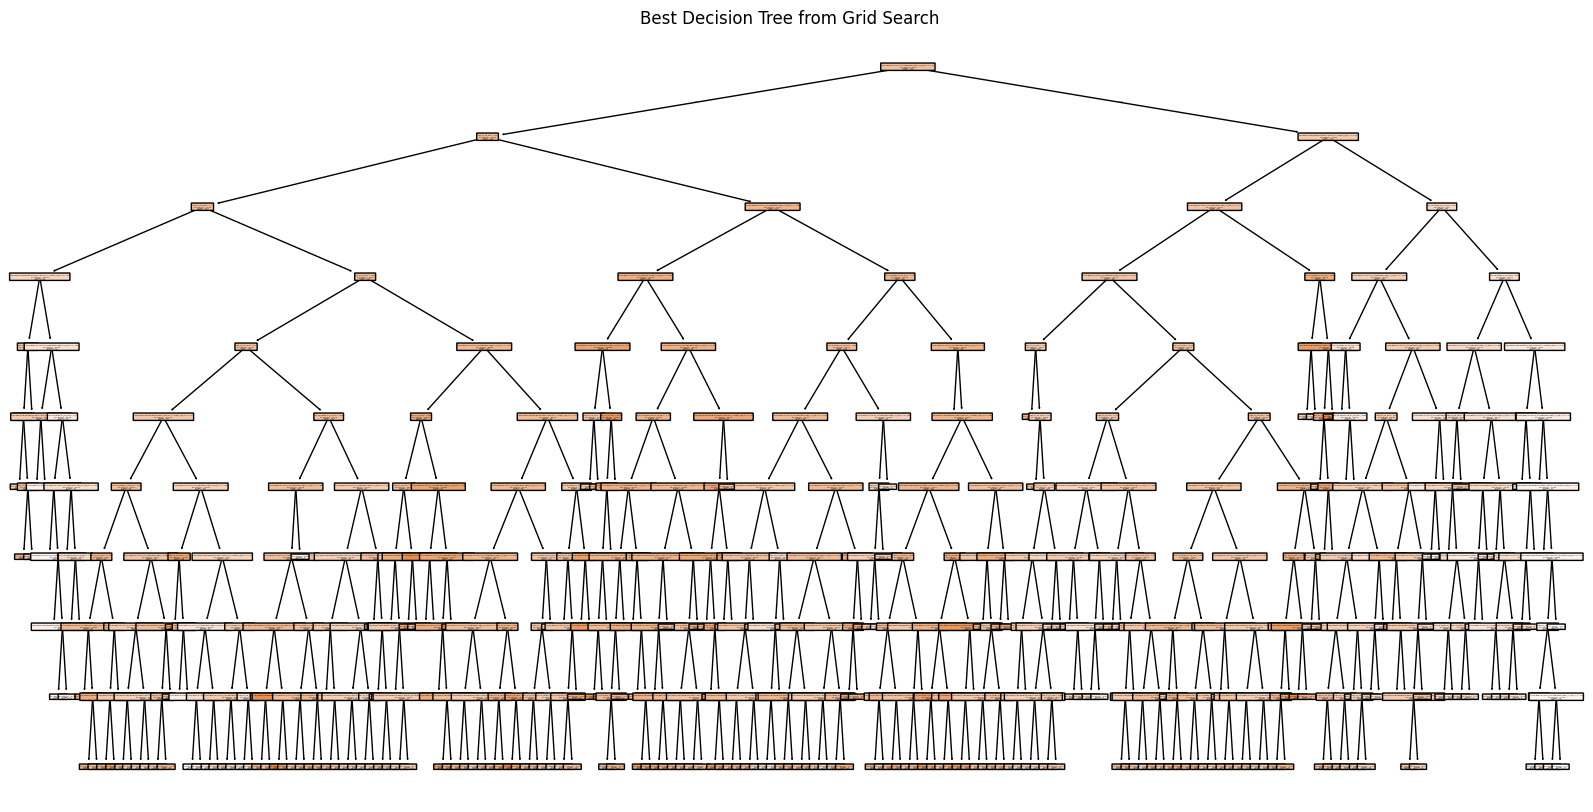

C:\Users\dstockman\AppData\Local\Temp\ipykernel_25068\1415904249.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


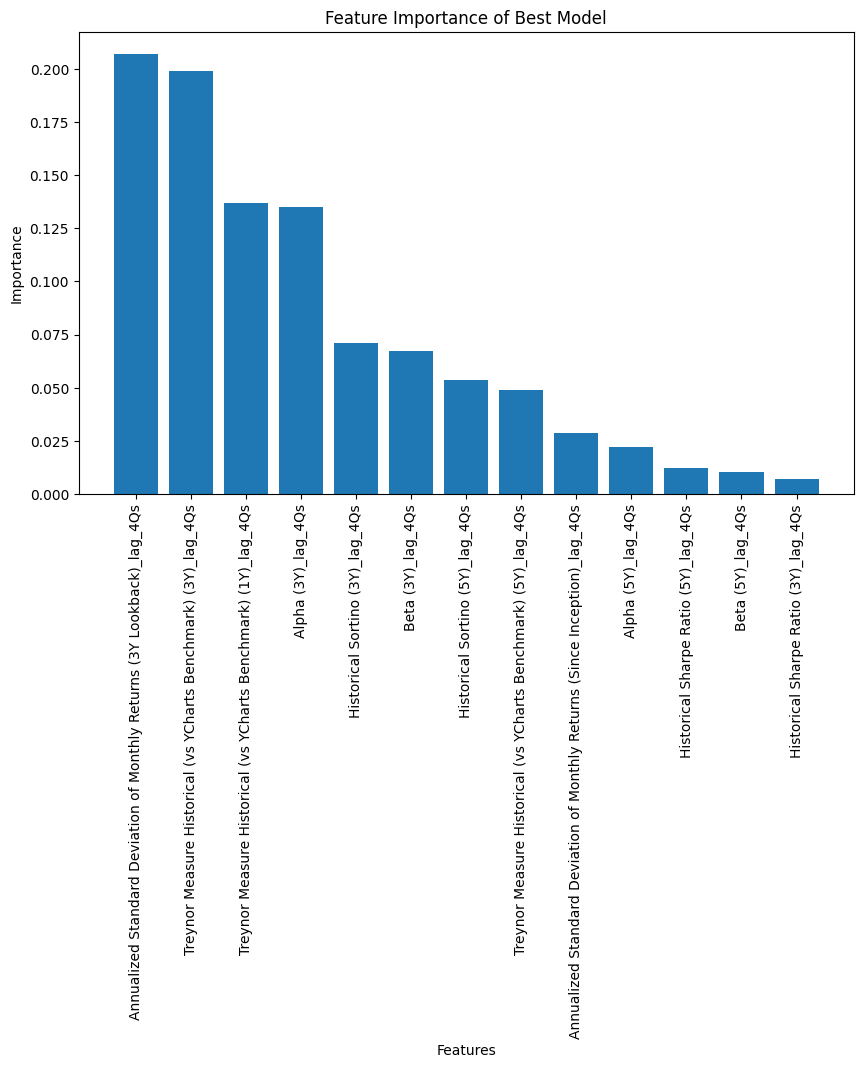

Mean Squared Error: 52.7253042764668


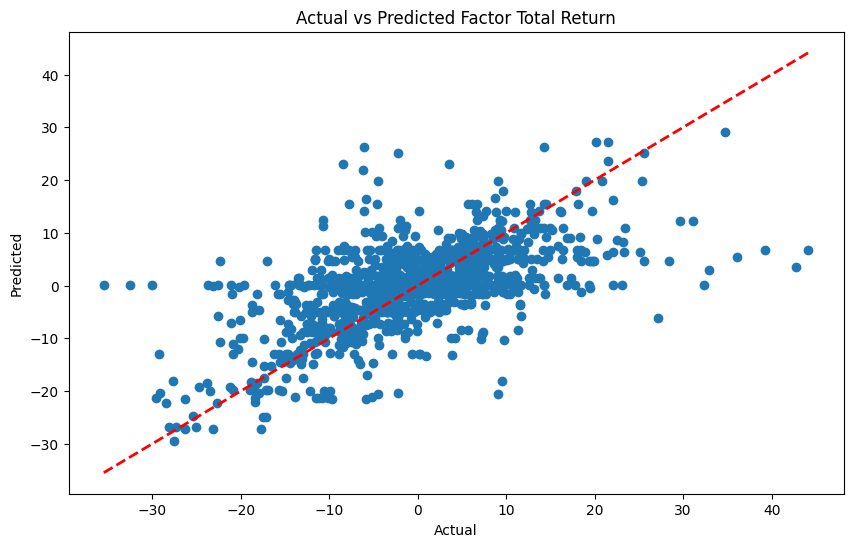

In [5]:
# Get the best model
best_DT = grid_search.best_estimator_

# Plot the best decision tree
plt.figure(figsize=(20,10))
plot_tree(best_DT, feature_names=X.columns, filled=True, rounded=True)
plt.title("Best Decision Tree from Grid Search")
plt.show()

# Plot feature importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': best_DT.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance of Best Model")
plt.tight_layout()
plt.show()

# Make predictions
y_pred = best_DT.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
# Plot predicted vs actual values
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Factor Total Return")
plt.show()

## eXtreme Gradient Boosting

In [6]:
# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline steps: Imputation, Scaling, and Model
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=-999)),   # Handle missing values if any
    #('scaler', StandardScaler()),                   # Scale the features
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror'))  # XGBoost Regressor
])

# Define the grid of hyperparameters to search
param_grid = {
    'xgb__max_depth': [5, 10, 15],
    'xgb__learning_rate': [ .01, 0.1],
    'xgb__n_estimators': [50,100, 150],
    'xgb__subsample': [0.8, 0.9],
    'xgb__colsample_bytree': [0.8, 0.9]
}

# Set up the GridSearchCV with the pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score from the grid search
print(f'Best parameters found: {grid_search.best_params_}')
print(f'Best score found: {grid_search.best_score_}')

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE of the best model: {rmse}')


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters found: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 100, 'xgb__subsample': 0.9}
Best score found: -37.76458052690272
RMSE of the best model: 5.679942442704161


c:\Users\dstockman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


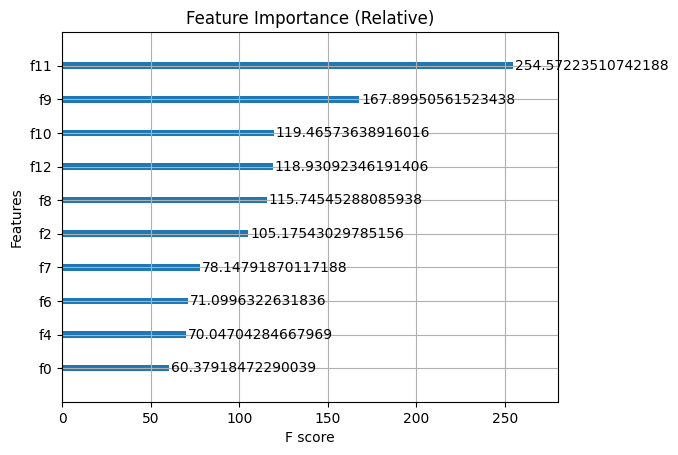

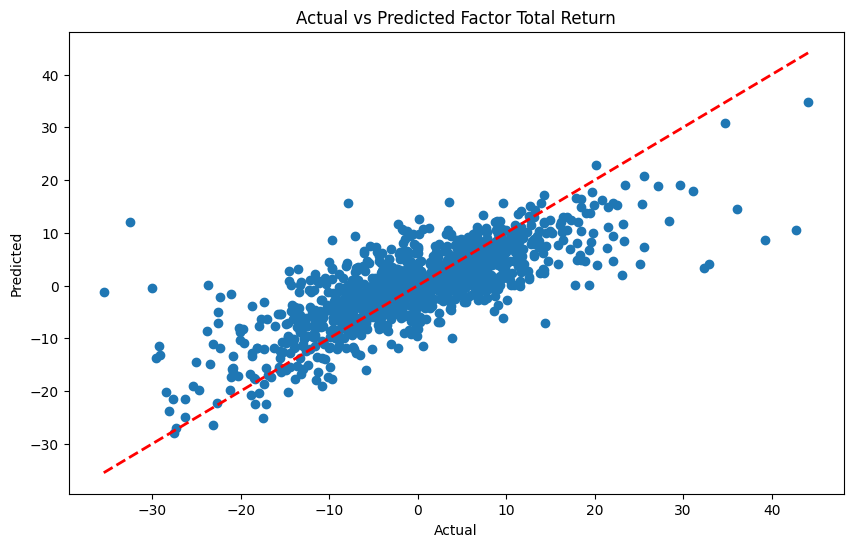

In [7]:
# Access the best estimator directly from the GridSearchCV
best_model_pipeline = grid_search.best_estimator_  # replace 'grid_search' with your GridSearchCV object

# Get the XGBoost model from the pipeline (assuming it's in the last step of the pipeline)
xgb_model = best_model_pipeline.named_steps['xgb']  # replace 'xgbregressor' with your actual XGB model step name

# Get the booster
best_booster = xgb_model.get_booster()

# Plot feature importance
xgb.plot_importance(best_booster, importance_type='gain', max_num_features=10)
plt.title("Feature Importance (Relative)")
plt.show()

# Plot predicted vs actual values
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Factor Total Return")
plt.show()


## Forecast with latest observation

In [8]:
# Select only the lagged features for prediction
X_latest = latest_obs[[f"{feature}_lag_4Qs" for feature in lagged_features]]

# Step 5: Predict using the XGBoost model
predicted_alpha = xgb_model.predict(X_latest)

# Extract fund identifiers for reference
fund_identifiers = latest_obs[["Symbol", "Name"]]
latest_features = latest_obs.drop(columns=["Symbol", "Name"], errors="ignore")

# Combine predictions with fund identifiers
latest_data_with_predictions = pd.DataFrame({
    "Symbol": fund_identifiers["Symbol"],
    "Name": fund_identifiers["Name"],
    "Predicted Alpha (1Y)": predicted_alpha
})

# Step 6: Rank funds based on predictions
ranked_funds = latest_data_with_predictions.sort_values(by="Predicted Alpha (1Y)", ascending=False)

# Display the top 10 predicted funds
print("Top 10 Predicted Funds for 12-31-2024:")
print(ranked_funds.head(10))



Top 10 Predicted Funds for 12-31-2024:
            Symbol                                           Name  \
95            FRTY                           Alger Mid Cap 40 ETF   
7295       M:VLMIX  Value Line Mid Cap Focused Fund Institutional   
4703       M:MXMGX   Empower T Rowe Price Mid Cap Growth Fund Inv   
2495       M:FGSIX  Federated Hermes MDT Mid Cap Growth Fund Inst   
191           JMID       Janus Henderson Mid Cap Growth Alpha ETF   
6047       M:RPTIX             T Rowe Price Mid-Cap Growth Fund I   
3551       M:JACFX           John Hancock Mid Cap Growth Fund NAV   
4127  M:LP40022161         JNL/T Rowe Price Mid-Cap Growth Fund A   
1919       M:CCMAX           Conestoga Mid Cap Fund Institutional   
7583          TMFM                 Motley Fool Mid-Cap Growth ETF   

      Predicted Alpha (1Y)  
95                5.401140  
7295              3.869384  
4703              1.184455  
2495              0.754799  
191               0.076902  
6047              0.074847 

In [ ]:
import shap
import matplotlib.pyplot as plt

# Use SHAP to explain the model predictions
explainer = shap.Explainer(xgb_model, X)
shap_values = explainer(X_latest)

# Create a summary plot with custom margins
plt.figure(figsize=(24, 8))  # Adjust the width and height of the plot
shap.summary_plot(shap_values, X_latest, show=False)

# Adjust margins further if needed
plt.subplots_adjust(left=0.2, right=1.8, top=0.9, bottom=0.1)  # Customize as needed

# Show the plot
plt.show()


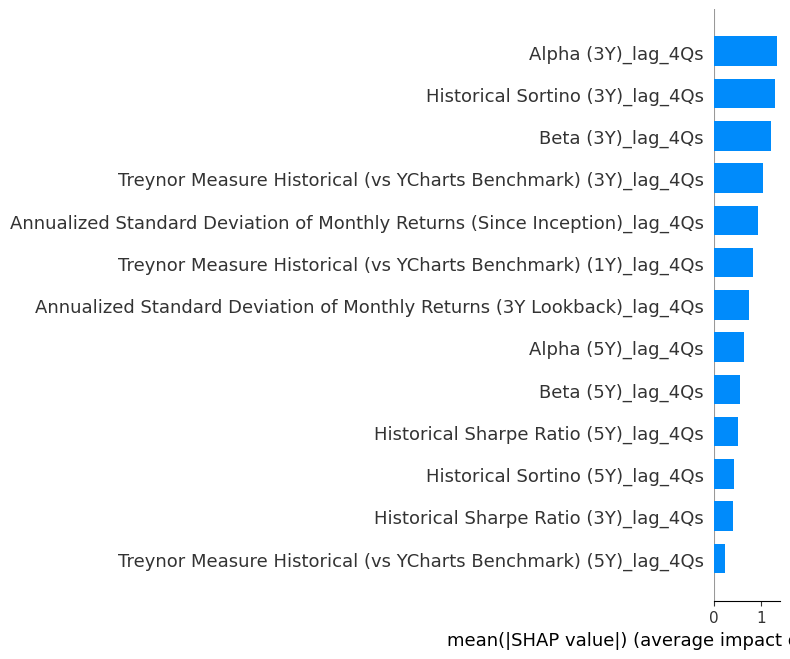

<Figure size 640x480 with 0 Axes>

In [11]:
# Extract the top 10 predicted funds
top_10_funds = ranked_funds.head(10)

# Filter the latest observations for the Top 10 funds
X_top_10 = X_latest.loc[top_10_funds.index]

# Use SHAP to explain the model predictions
explainer = shap.Explainer(xgb_model, X)
shap_values_top_10 = explainer(X_top_10)
# Plot a SHAP summary plot for the Top 10 funds
shap.summary_plot(shap_values_top_10, X_top_10, plot_type="bar", show=True)
# Adjust margins further if needed
plt.subplots_adjust(left=0.2, right=1.8, top=0.9, bottom=0.1)  # Customize as needed

# Show the plot
plt.show()


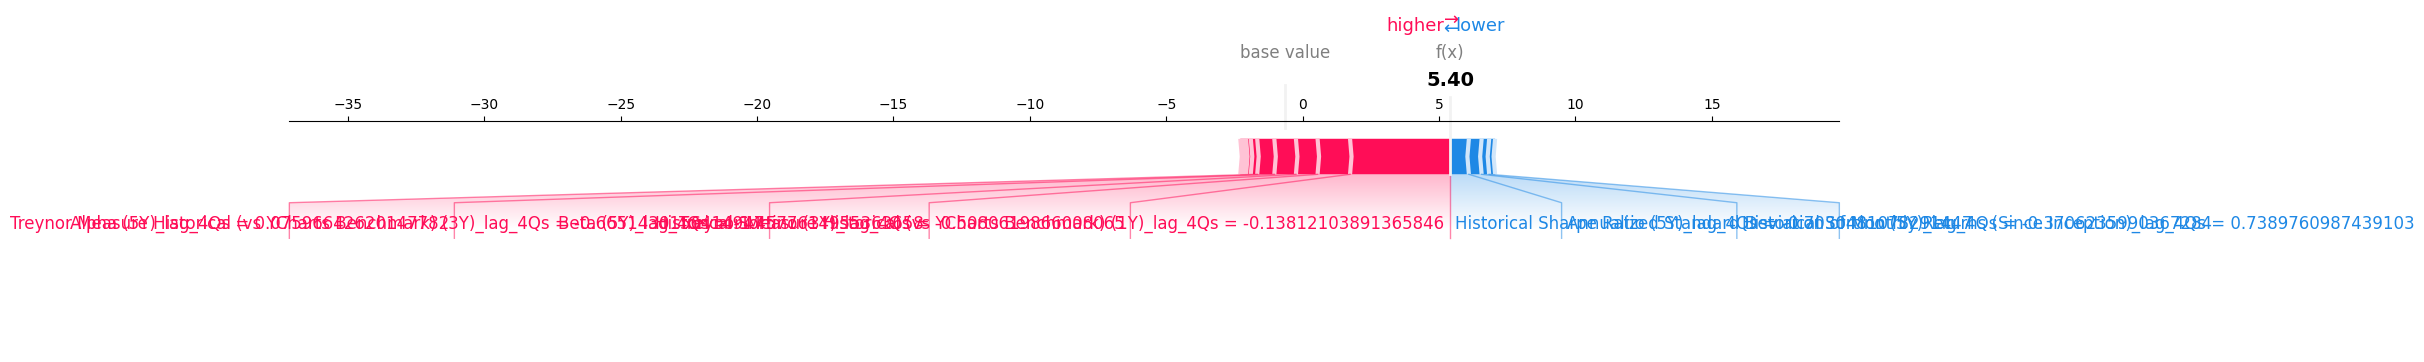

Force Plot for Fund: Alger Mid Cap 40 ETF


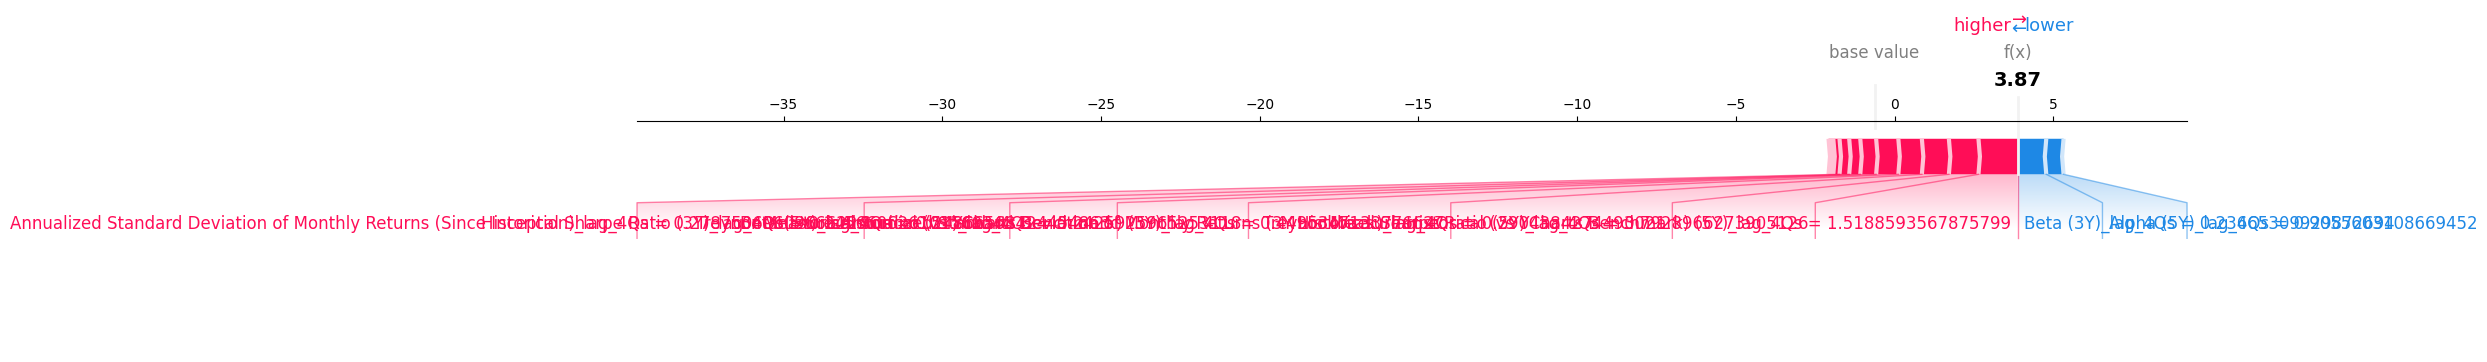

Force Plot for Fund: Value Line Mid Cap Focused Fund Institutional


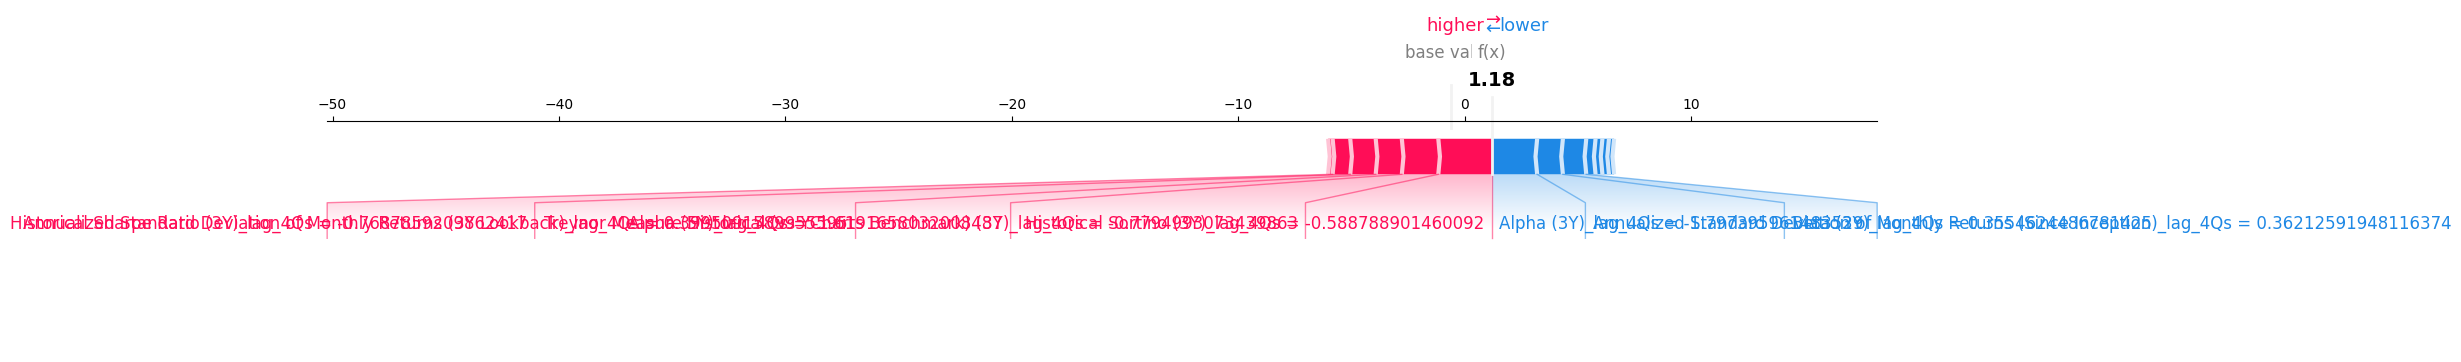

Force Plot for Fund: Empower T Rowe Price Mid Cap Growth Fund Inv


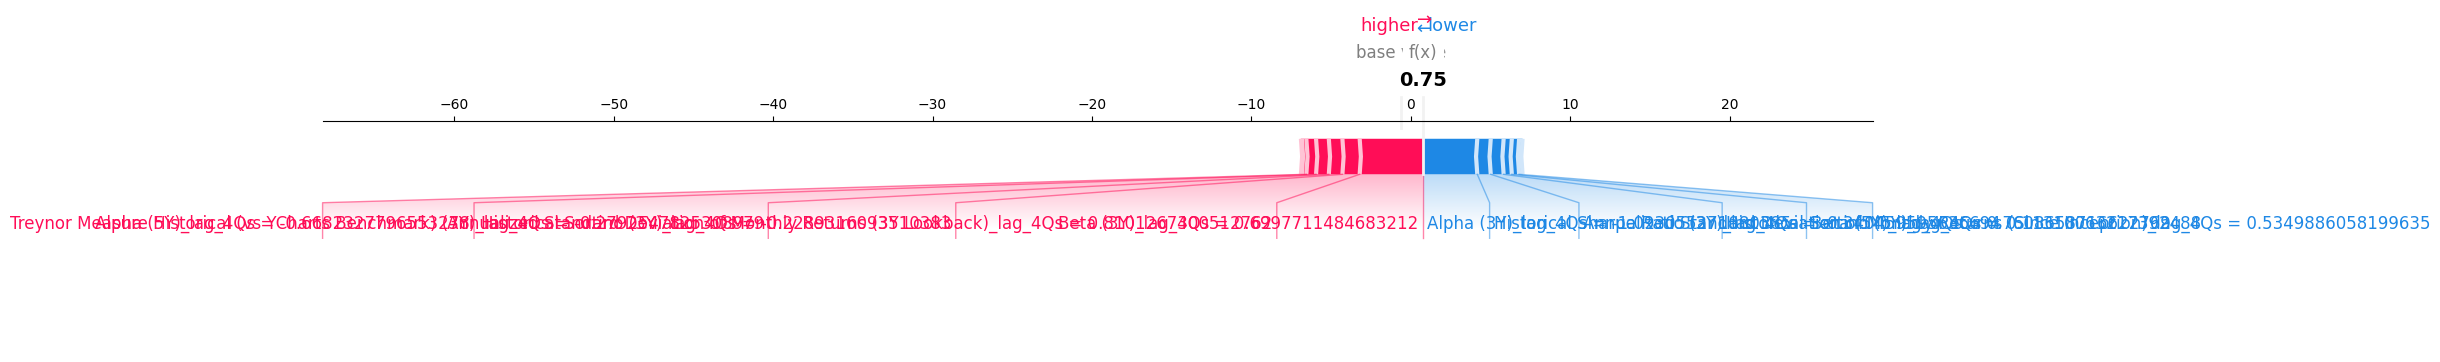

Force Plot for Fund: Federated Hermes MDT Mid Cap Growth Fund Inst


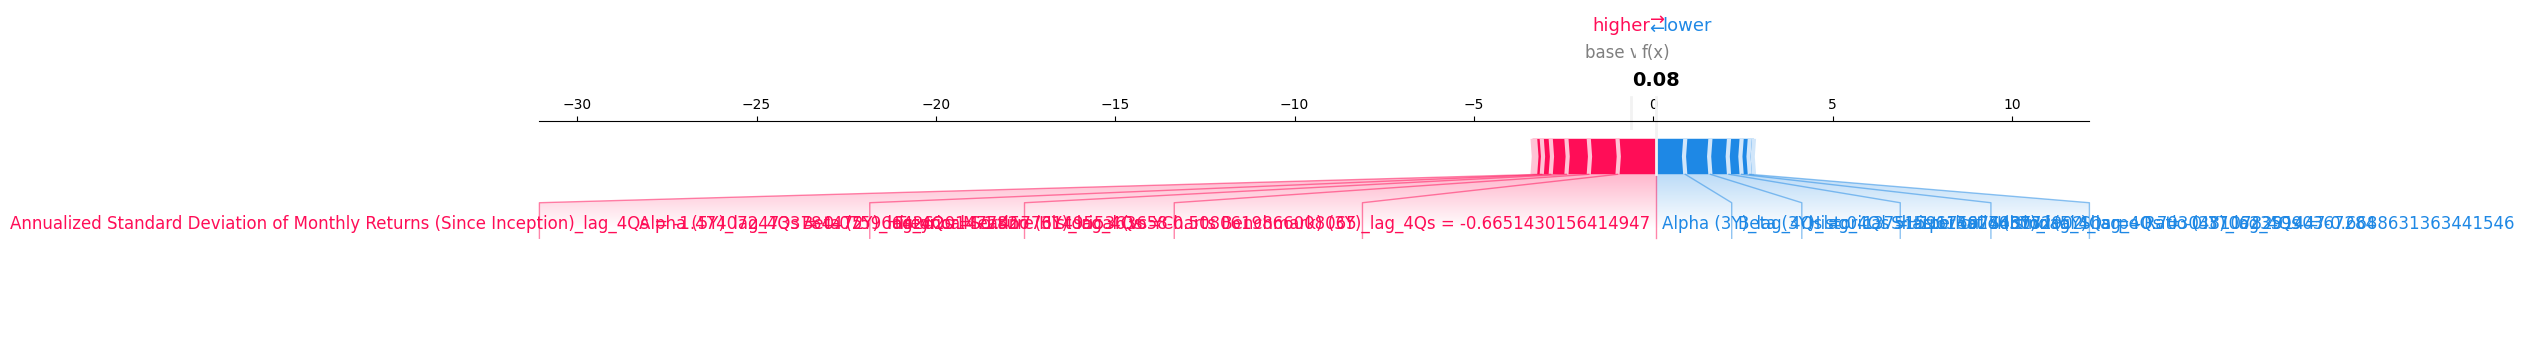

Force Plot for Fund: Janus Henderson Mid Cap Growth Alpha ETF


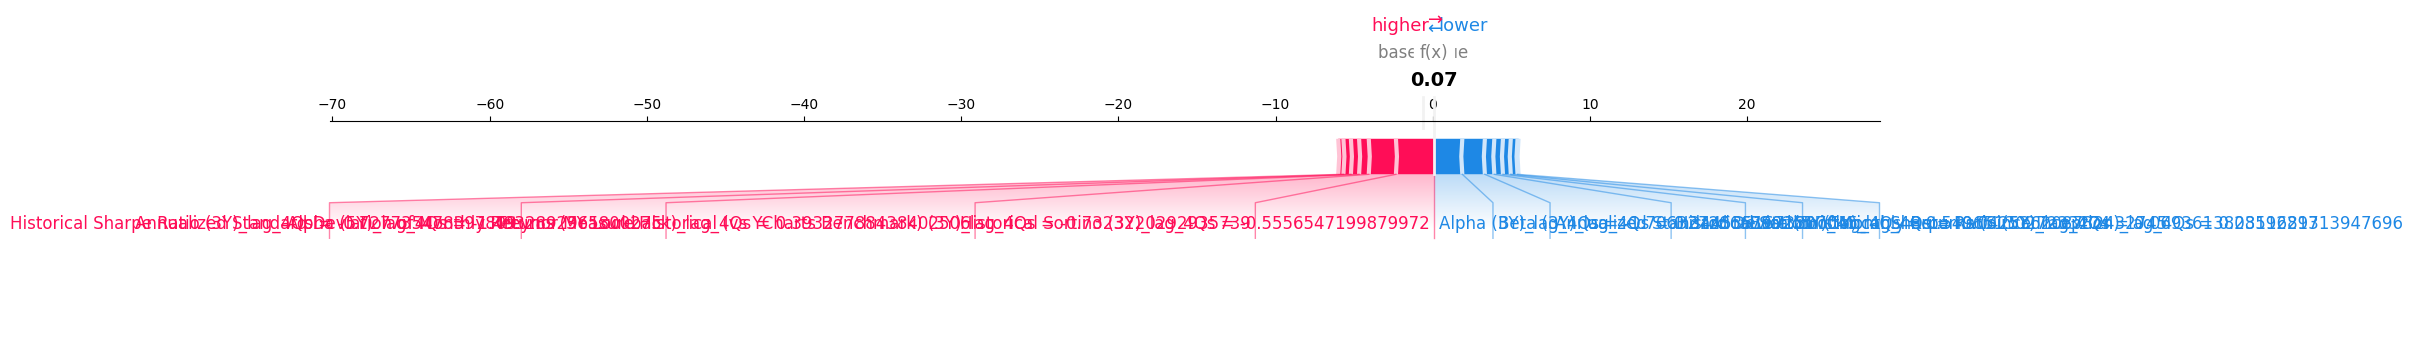

Force Plot for Fund: T Rowe Price Mid-Cap Growth Fund I


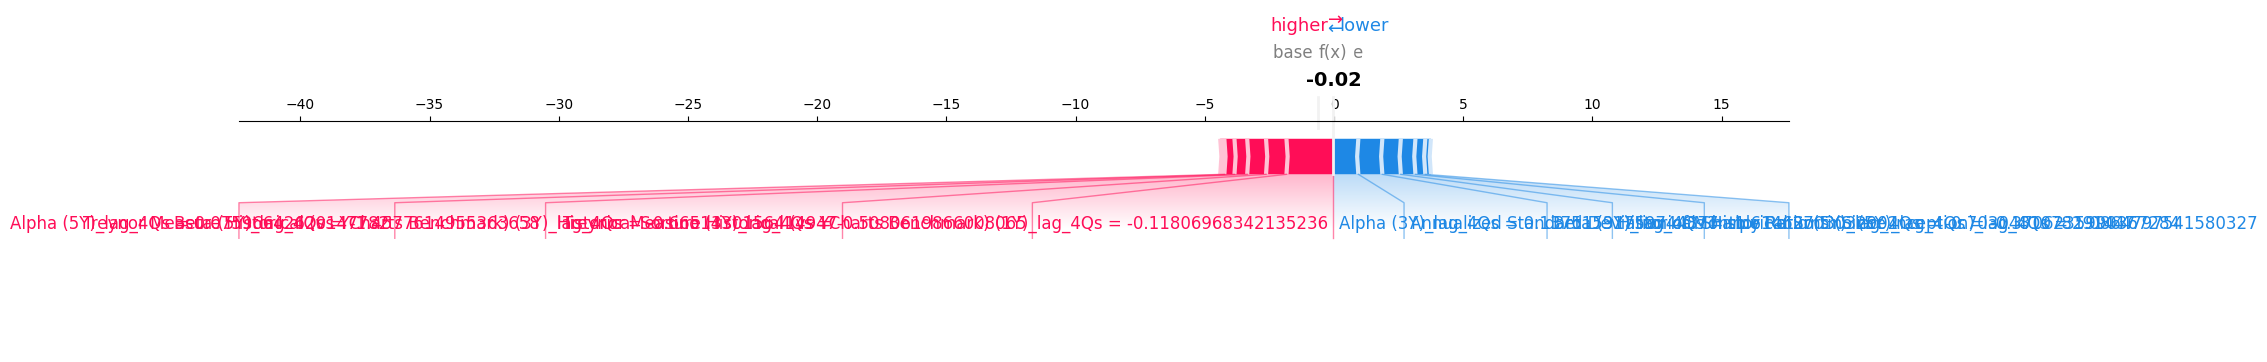

Force Plot for Fund: John Hancock Mid Cap Growth Fund NAV


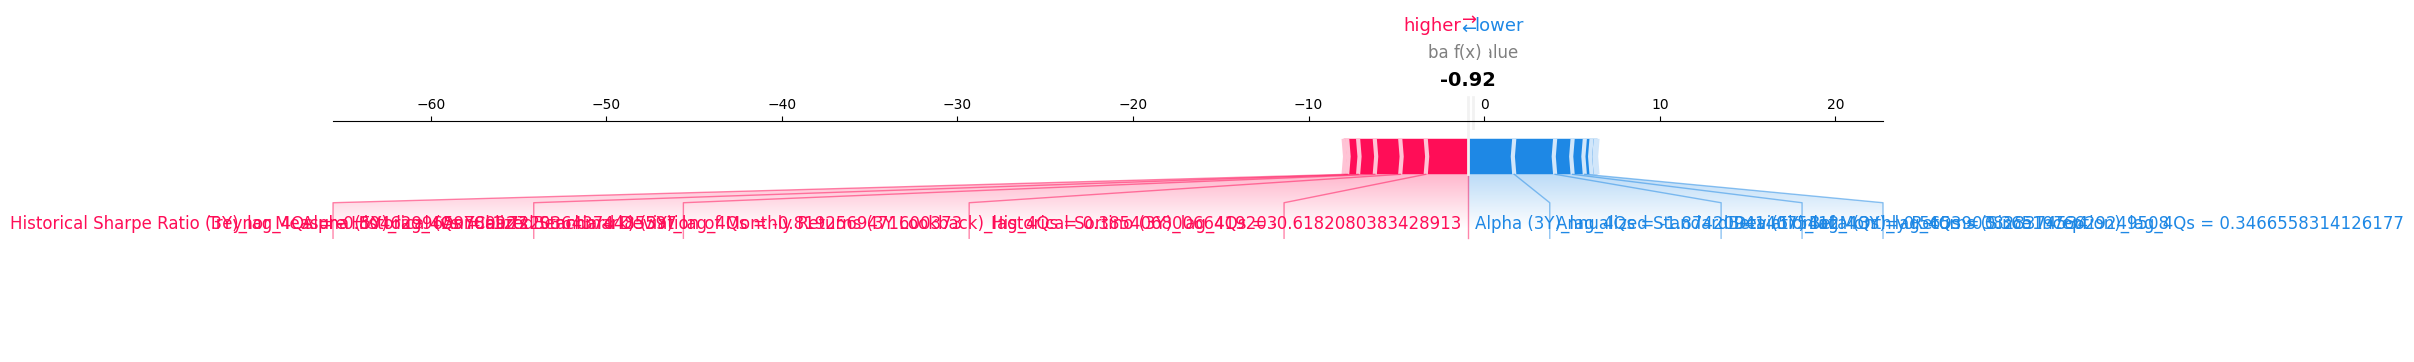

Force Plot for Fund: JNL/T Rowe Price Mid-Cap Growth Fund A


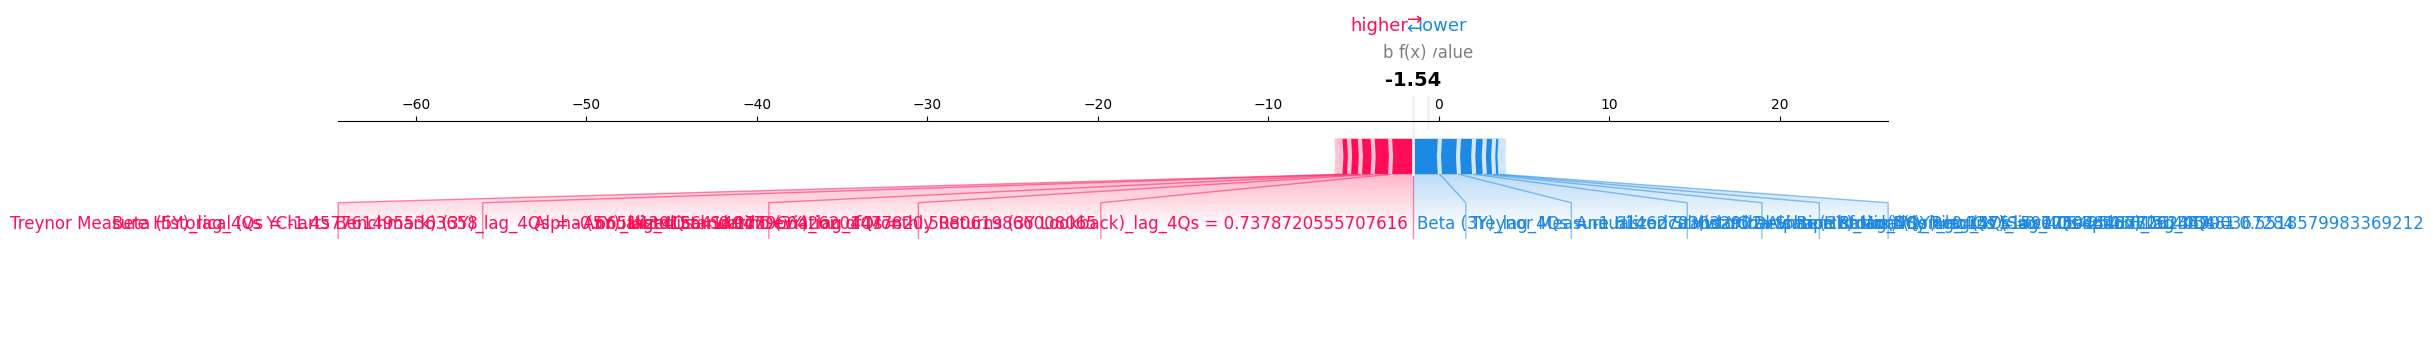

Force Plot for Fund: Conestoga Mid Cap Fund Institutional


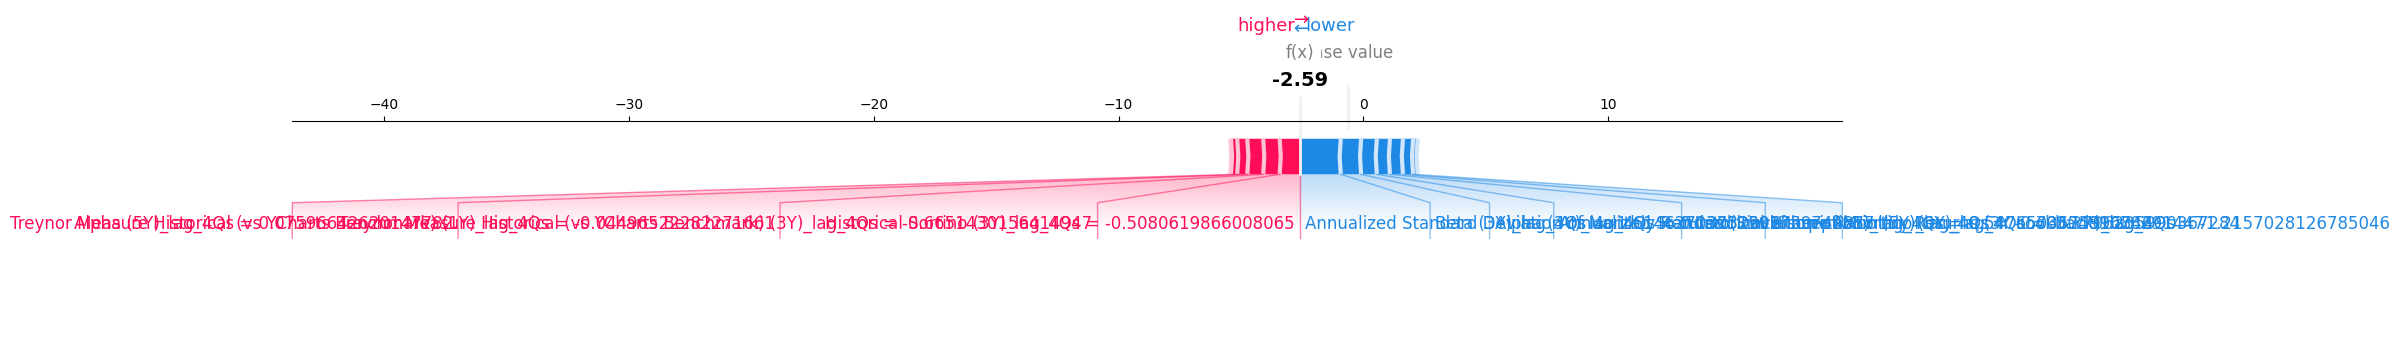

Force Plot for Fund: Motley Fool Mid-Cap Growth ETF


In [14]:
# Generate individual force plots for each fund
for i, index in enumerate(X_top_10.index):
    shap.force_plot(
        explainer.expected_value,
        shap_values_top_10[i].values,
        X_top_10.iloc[i],
        matplotlib=True,
        show=True
    )
    print(f"Force Plot for Fund: {top_10_funds.iloc[i]['Name']}")
